In [180]:
import json
import pathlib
import pickle
import re

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from matplotlib import pyplot as plt

from labm8.py import humanize

import numpy as np
import pandas as pd
from third_party.py.tensorflow import tf
from labm8.py import app
from labm8.py import app
from labm8.py import app
from graph_nets.demos import models as gn_models
from graph_nets import utils_np as graph_net_utils_np

from deeplearning.deeptune.opencl.heterogeneous_mapping import utils
from deeplearning.deeptune.opencl.heterogeneous_mapping.models import models
from labm8.py import prof
from labm8.py import viz

flags.FLAGS(['argv[0]'])

%matplotlib inline

## Read experimental data

Run training with:

```sh
rm -rf /tmp/phd/docs/wip_graph/train_model && bazel run //docs/wip_graph/notebooks:04_train_model -- --v=1 --df=/var/phd/shared/docs/wip_graph/lda_opencl_device_mapping_dataset.pkl --outdir=/tmp/phd/docs/wip_graph/train_model --num_epochs=2 --experimental_force_num_processing_steps=10 --experimental_maximum_split_count=2
```

Use tensorboard with:

```sh
python -m tensorboard.main --logdir='/tmp/phd/docs/wip_graph/train_model/tensorboard'
```

In [193]:
def ReadTelemetryFiles(outdir: pathlib.Path, group: str):
    outdir = pathlib.Path(outdir)
    if not (outdir / 'telemetry').is_dir():
        return []
    logs = []
    for json_file in (outdir / 'telemetry').iterdir():
        with open(json_file) as f:
            log = json.load(f)
        logs.append(log)
        log['group'] = group
        log['training_loss'] = sum(log['training_losses']) / len(log['training_losses'])
    return logs

telemetries = (
    ReadTelemetryFiles('/var/phd/shared/docs/wip_graph/models/opencl_devmap/graph/amd', 'OpenCL-amd') +
    ReadTelemetryFiles('/var/phd/shared/docs/wip_graph/models/opencl_devmap/graph/nvidia', 'OpenCL-nvidia') +
    ReadTelemetryFiles('/var/phd/shared/docs/wip_graph/models/reachability/graph/ocl', 'Reachability-OpenCL') +
    ReadTelemetryFiles('/var/phd/shared/docs/wip_graph/models/reachability/graph/linux', 'Reachability-Linux'))

df = pd.DataFrame(telemetries).sort_values(by=['group', 'epoch'])
df.shape

(158, 26)

## Results Overview

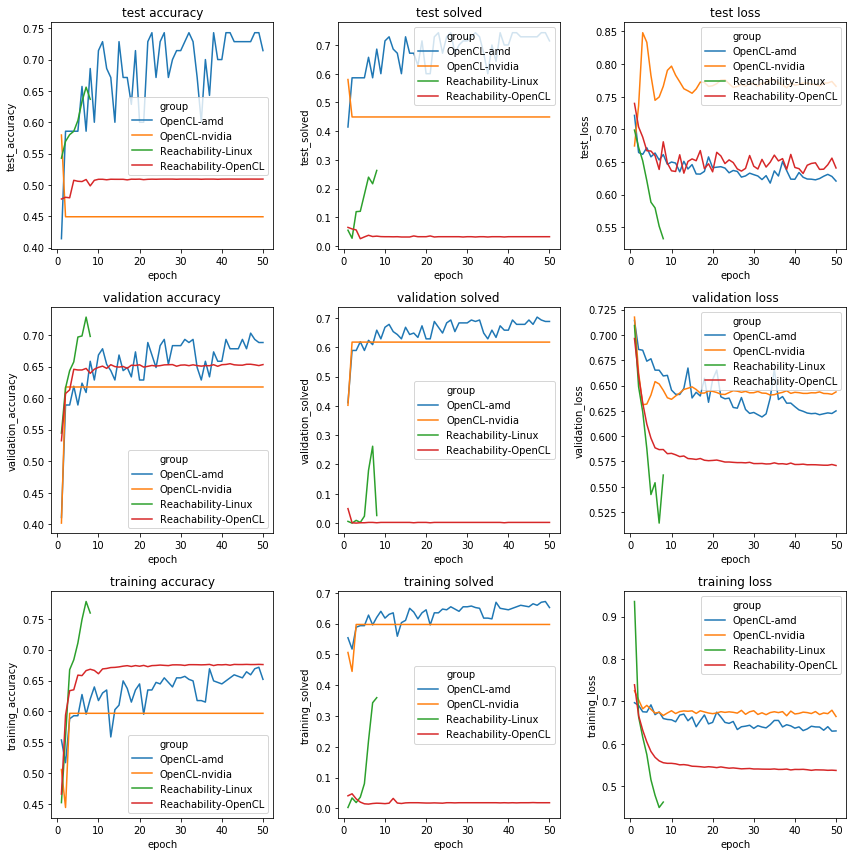

In [194]:
fig = plt.figure(figsize=(12, 12))
fig.clf()

for j, row in enumerate(['test', 'validation', 'training']):
    ax = fig.add_subplot(3, 3, j * 3 + 1)
    sns.lineplot('epoch', f'{row}_accuracy', hue='group', data=df, ax=ax)
    ax.set_title(f'{row} accuracy')

    ax = fig.add_subplot(3, 3, j * 3 + 2)
    sns.lineplot('epoch', f'{row}_solved', hue='group', data=df, ax=ax)
    ax.set_title(f'{row} solved')

    ax = fig.add_subplot(3, 3, j * 3 + 3)
    sns.lineplot('epoch', f'{row}_loss', hue='group', data=df, ax=ax)
    ax.set_title(f'{row} loss')

viz.finalise()

### Learning rates

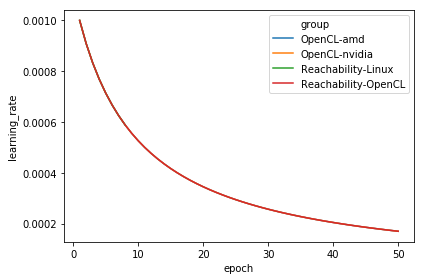

In [195]:
sns.lineplot('epoch', 'learning_rate', hue='group', data=df)
plt.xlabel('epoch')
plt.ylabel('learning_rate')
viz.finalise()

### Loss

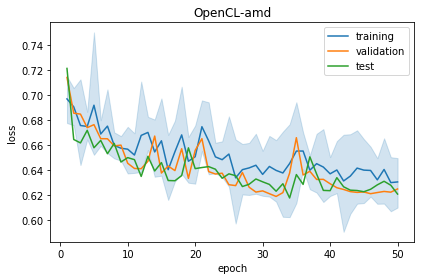

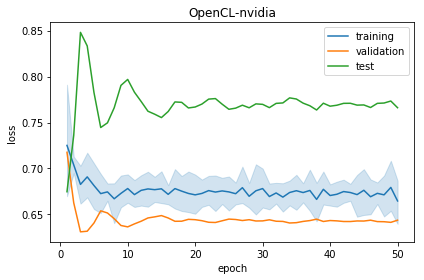

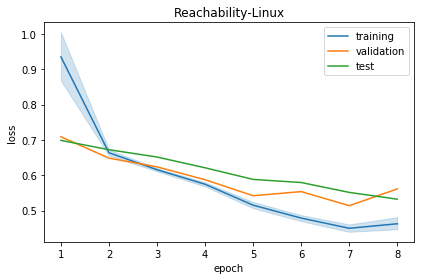

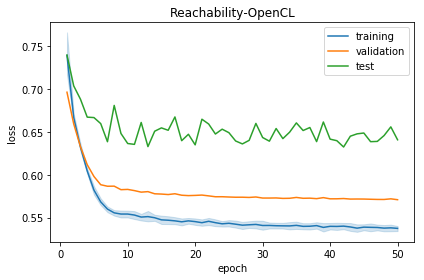

In [196]:
def TableOfAllTrainingLosses(df: pd.DataFrame):
    losses = []
    for _, row in df.iterrows():
        for loss in row['training_losses']:
            losses.append({
                'epoch': row['epoch'],
                'group': row['group'],
                'loss': loss,
            })
    return pd.DataFrame(losses)

groups = sorted(set(df['group']))
for i, group in enumerate(groups):
    df_to_plot = df[df['group'] == group]
    sns.lineplot('epoch', 'loss', data=TableOfAllTrainingLosses(df_to_plot), label='training')
    sns.lineplot('epoch', 'validation_loss', data=df_to_plot, label='validation')
    sns.lineplot('epoch', 'test_loss', data=df_to_plot, label='test')
    plt.ylabel('loss')
    plt.legend()
    plt.title(group)
    viz.finalise()

### Accuracy

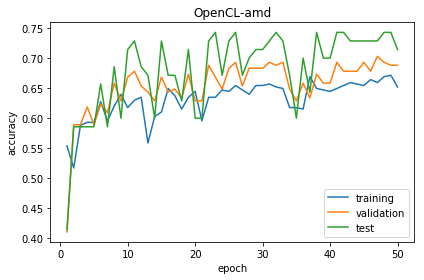

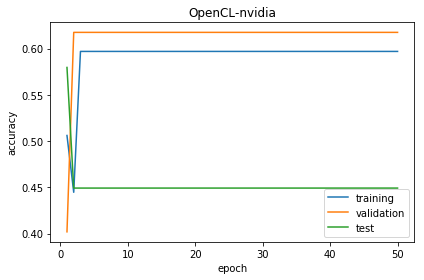

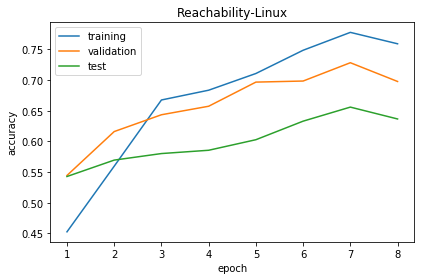

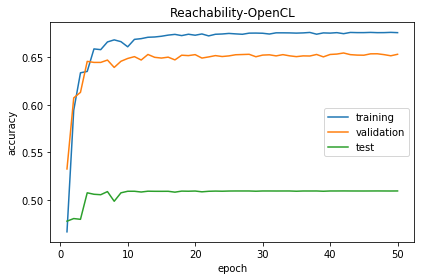

In [197]:
groups = sorted(set(df['group']))
for i, group in enumerate(groups):
    df_to_plot = df[df['group'] == group]
    sns.lineplot('epoch', 'training_accuracy', data=df_to_plot, label='training')
    sns.lineplot('epoch', 'validation_accuracy', data=df_to_plot, label='validation')
    sns.lineplot('epoch', 'test_accuracy', data=df_to_plot, label='test')
    plt.ylabel('accuracy')
    plt.title(group)
    viz.finalise()

## Solved

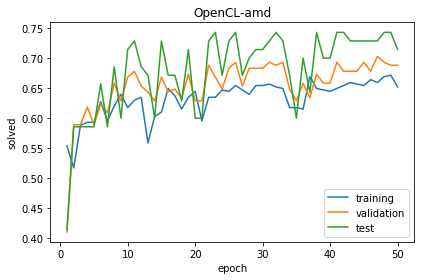

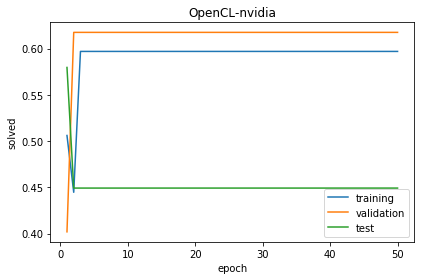

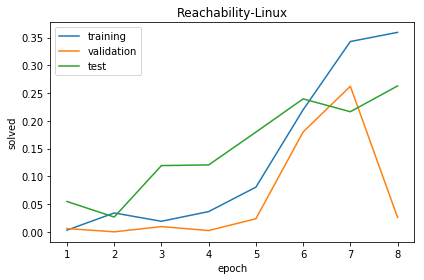

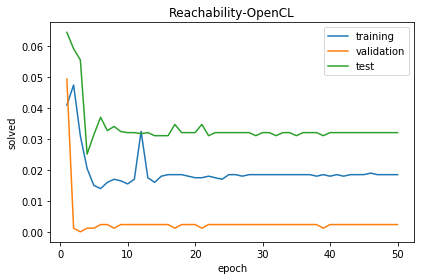

In [198]:
groups = sorted(set(df['group']))
for i, group in enumerate(groups):
    df_to_plot = df[df['group'] == group]
    sns.lineplot('epoch', 'training_solved', data=df_to_plot, label='training')
    sns.lineplot('epoch', 'validation_solved', data=df_to_plot, label='validation')
    sns.lineplot('epoch', 'test_solved', data=df_to_plot, label='test')
    plt.ylabel('solved')
    plt.title(group)
    viz.finalise()

In [199]:
# Epoch with highest accuracy on the validation set.
groups = sorted(set(df['group']))

rows = []
for i, group in enumerate(groups):
    group_df = df[df['group'] == group]
    idxmax = group_df['validation_accuracy'].idxmax()
    best_result = group_df.loc[idxmax]
    rows.append({
        'Group': group,
        'Epoch #': f"{best_result['epoch']} / {group_df['epoch'].max()}",
        'Validation accuracy': f"{best_result['validation_accuracy']:.2%}",
        'Test accuracy': f"{best_result['test_accuracy']:.2%} ({group_df['test_accuracy'].max():.2%})",
        'Test solved': f"{best_result['test_solved']:.2%} ({group_df['test_solved'].max():.2%})",
    })
pd.DataFrame(rows, columns=['Group', 'Epoch #', 'Validation accuracy', 'Test accuracy', 'Test solved'])

,Group,Epoch #,Validation accuracy,Test accuracy,Test solved
0,OpenCL-amd,47 / 50,70.30%,72.86% (74.29%),72.86% (74.29%)
1,OpenCL-nvidia,2 / 50,61.76%,44.93% (57.97%),44.93% (57.97%)
2,Reachability-Linux,7 / 8,72.84%,65.60% (65.60%),21.65% (26.30%)
3,Reachability-OpenCL,42 / 50,65.45%,50.94% (50.94%),3.21% (6.45%)
